In [1]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import re
import sys,os
from wordcloud import WordCloud

from urllib.parse import urlparse

In [2]:
from math import log
from re import compile
from urllib.parse import urlparse
from socket import gethostbyname
from pyquery import PyQuery
from requests import get
from json import dump
from string import ascii_lowercase
from numpy import array

In [3]:
# for model building 
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

c:\Users\Adarsha\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
df = pd.read_csv(r"urldata(NEW).csv")
df

,url,type
0,https://www.google.com,benign
1,https://www.youtube.com,benign
2,https://www.facebook.com,benign
3,https://www.baidu.com,benign
4,https://www.wikipedia.org,benign
...,...,...
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious
450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious
450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious
450174,http://atualizapj.com/,malicious


In [5]:
df.type.value_counts()

benign       345738
malicious    104438
Name: type, dtype: int64

In [6]:
# to check if there's any null values
#checking if the dataset contains any null values 
df.isna().sum()

url     0
type    0
dtype: int64

In [7]:
df.describe().T

,count,unique,top,freq
url,450176,450176,https://www.google.com,1
type,450176,2,benign,345738


In [6]:
# df['type'].replace({'defacement': 'bad', 'phishing' : 'bad', 'malware':'bad'}, inplace=True)
# df

# Word Cloud

In [8]:
df_benign = df[df.type == 'benign']
df_malicious = df[df.type == 'malicious']

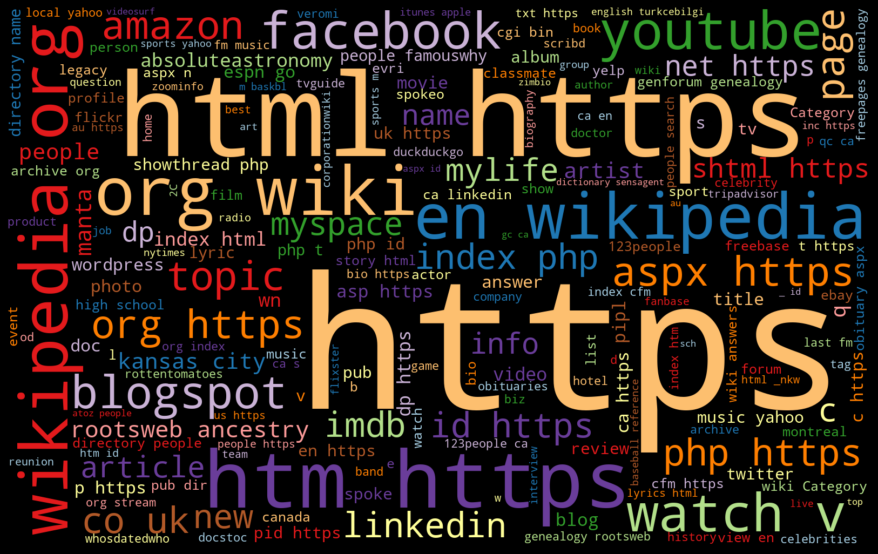

In [9]:
benign = " ".join (i for i in df_benign.url)
wordcloud = WordCloud(width = 1600, height = 1000, colormap = 'Paired').generate(benign)
plt.figure(figsize= (12, 14), facecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad =0)
plt.show()


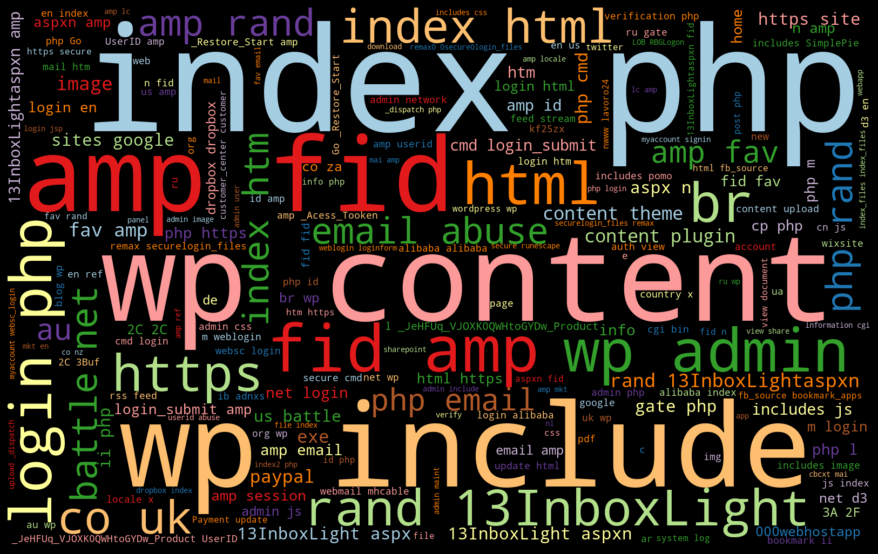

In [10]:
malicious = " ".join (i for i in df_malicious.url)
wordcloud = WordCloud(width = 1600, height = 1000, colormap = 'Paired').generate(malicious)
plt.figure(figsize= (12, 14), facecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad =0)
plt.show()


# Inferences 

1. Benign URLs have frequent tokens like https, html, htm, en wikipedia, org, wiki, blogspot, youtube, wikipedia, etc.
2. Malicious URLs have frequent tokens like include, index, php, fid, amp, wp, content, login, br, admin, etc.


Therefore, inorder to classify whether the url is malicious or not, we can tokenize the url and fit into the Tf-idf Vectorizer which basically calculates the frequency of the tokens. This way a model can be trained to identify most frequent patterns in the URL in order to determine whether the URL is malicious or not.

## TOKENIZATION

In [5]:

def tokenizer(url):

  
  # Split by slash (/) and dash (-)
  tokens = re.split('[/-]', url)
  
  for i in tokens:
    # Include the splits extensions and subdomains
    if i.find(".") >= 0:
      dot_split = i.split('.')
      
      # Remove .com and www. since they're too common
      if "com" in dot_split:
        dot_split.remove("com")
      if "www" in dot_split:
        dot_split.remove("www")
      
      tokens += dot_split
      
  return tokens


# Testing the Tokenizer()

In [6]:
test_url = df['url'][40000] # just a random url to test whether the tokenizer works or not
test_url

'https://www.en.wikipedia.org/wiki/The_Ice_Harvest'

In [13]:
tokenized_url = tokenizer(test_url)
tokenized_url

['https:',
 '',
 'www.en.wikipedia.org',
 'wiki',
 'The_Ice_Harvest',
 'en',
 'wikipedia',
 'org']

In [14]:
# Manually perform term count on test_df
for i in list(dict.fromkeys(tokenized_url)):
  print("{} - {}".format(tokenized_url.count(i), i))

1 - https:
1 - 
1 - www.en.wikipedia.org
1 - wiki
1 - The_Ice_Harvest
1 - en
1 - wikipedia
1 - org


# Train Test Split

In [6]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(df['url'], df['type'], test_size=0.2, random_state=42)

In [7]:
print( "The number of records in the training dataset is", X_train.shape[0])
print("The number of records in the testing dataset is", X_test.shape[0])

The number of records in the training dataset is 360140
The number of records in the testing dataset is 90036


# Fit the TfidfVectorizer

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
train_vectors = vectorizer.fit_transform(X_train)


In [72]:
print(type(vectorizer))
# print(len(vectorizer))

<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


# Save the vectorizer model

In [80]:
import joblib

joblib.dump(vectorizer, 'vectorizer.sav' )

['vectorizer.sav']

In [58]:
# import joblib

# joblib.dump((vectorizer, tokenizer), 'vectorizer_and_tokenizer.pkl')

['vectorizer_and_tokenizer.pkl']

# Test Vectors

In [9]:
test_vectors = vectorizer.transform(X_test)

# Exploratory Data Analysis (EDA)

In [19]:
# compute the frequency of each token

token_freq = train_vectors.sum(axis = 0).A1
token_dict = {t: i for i, t in enumerate(vectorizer.get_feature_names())}
sorted_tokens = sorted(token_dict, key=lambda t: -token_freq[token_dict[t]])
top_tokens = sorted_tokens[:100]

c:\Users\Adarsha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


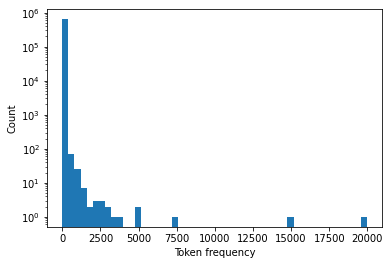

In [20]:
plt.hist(token_freq, bins=50, log=True)
plt.xlabel('Token frequency')
plt.ylabel('Count')
plt.show()

Okay so surprisingly it took me a bit of time to interpret this histogram plot. Here's the inference :

1. X- axis contains token frequency meaning that how many times a particular word (token) has appeared in the dataset 
2. Y- axis contains the count of number of tokens that fall in the particular frequency bin 

example to interpret this: -->
consider the word 'wikipedia' appears 10 times; the token frequency of wikipedia is 10, 
if frequency bin (X-axis ) for tokens that appears 10 times appears in the y-axis with the count of 500,
it means that 500 different tokens that appear exactly 10 times in the dataset

# Model Building

In [45]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(train_vectors, y_train)

RandomForestClassifier(random_state=0)

# SAVE THE MODEL SAV


In [14]:
import joblib

joblib.dump(model, 'RF_MODEL_URL-newDataset.sav')

['RF_MODEL_URL-newDataset.sav']

# Load the saved model 

In [10]:
import joblib

model = joblib.load('RF_MODEL_URL-newDataset.sav')

In [11]:
#  Use the trained model to classify the URLs in the test set.
predictions = model.predict(test_vectors)

# Evaluate the performance of the model

In [12]:
# Evaluate the performance of the model

acc = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions, pos_label = 'malicious')
recall = recall_score(y_test, predictions, pos_label = 'malicious')
f1 = f1_score(y_test, predictions, pos_label = 'malicious')
f2 = fbeta_score(y_test, predictions, beta=2, pos_label= 'malicious')

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", recall)
print("F1 Score:", f1)
print("F2 score:", f2)

Accuracy: 0.9953574125905194
Precision: 0.9994690863458661
Recall: 0.9807246033625385
F1 Score: 0.9900081273605202
F2 score: 0.9844170414246192


# Confusion Matrix

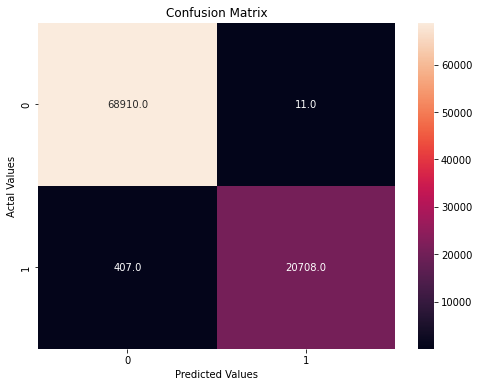

In [13]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Feature Importance

In [14]:
# don't try this, if you want your laptop alive!!!!!!!


# importances = model.feature_importances_

# # Sort the feature importances in descending order
# sorted_indices = importances.argsort()[::-1]
# sorted_importances = importances[sorted_indices]

# # Plot the feature importances
# plt.figure(figsize=(10,6))
# plt.bar(range(train_vectors.shape[1]), sorted_importances)
# plt.xticks(range(train_vectors.shape[1]), sorted_indices, rotation=90)
# plt.title("Feature Importances")
# plt.show()

# DUMMY PREDICTION 

In [15]:
X_predict= ['www.google.com/search?client=firefox-b-d&q=cat']

In [16]:
X_predict = vectorizer.transform(X_predict)
New_predict = model.predict(X_predict)
print(New_predict)

['benign']


In [49]:
X_predict = ['https://widget.rave.office.net/chat?partner=GetHelp&requestid=8b8fff76-844a-485b-8537-a46df82fc1b6',
'https://chat.openai.com/chat',
'https://monkeytype.com/',
'https://exam.ioe.edu.np/',
'https://www.zscaler.com/blogs/security-research/look-top-websites-blocked',
'https://www.ioenotes.edu.np/',
'https://chat.openai.com/chat',
'https://tribhuvan-university.edu.np/downloads/6',
'br-icloud.com.br',
'www.boxingnovascotia.com/index.html',
'https://www.youtube.com/watch?v=5L8-g6melVY']

In [51]:

X_predict = vectorizer.transform(X_predict)
New_predict = model.predict(X_predict)
print(New_predict)

['benign' 'benign' 'benign' 'benign' 'benign' 'benign' 'benign' 'benign'
 'malicious' 'malicious' 'benign']


In [15]:
# for benign sites

X_predict = ['https://myspace.com/lesbrunettesmusique',
'https://myspace.com/metalchallenger',
'https://myspace.com/mrentertainmentandthepookiesmackers',
'https://tv.com/shows/the-ellen-degeneres-show/',
'https://tv3winchester.com/home/headlines/Former_Frederick_County_Superintendent_Thomas_Malcolm_Jr_Recognized_130247373.html',
'https://local.yahoo.com/info-43048876-van-horn-william-a-md-van-horn-william-a-md-conway',
'https://ncbi.nlm.nih.gov/pmc/articles/PMC1479962/',
'https://ndscs.nodak.edu/',
'https://nebrwesleyan.edu/alumni-and-friends',
'https://rediff.com/movies/report/spotted-anupam-kher/20111025.htm',
'https://rediff.com/sports/slide-show/slide-show-1-french-open-2011-photos-agony-and-ecstasy-at-the-french-open/20110606.htm',
'https://redstate.com/gawken/2011/08/22/now-that-qadafi-is-gone-we-need-to-find-and-return-home-the-remains-of-capt-paul-f-lorence-usaf-kia-4151986-operation-el-dorado-canyon-lest-we-forget/',
'https://redtube.com/52289',
'https://redwineshiraz.com/knappstein-shiraz-20072008-clare-valley/',
'https://www.reeec.illinois.edu/faculty/library/feature/balkan/index.html',
'https://reelz.com/movie-news/6966/screenwriters-roberto-orci-and-alex-kurtzman-talk-cowboys-and-aliens-star-trek-2/',
'https://reference.com/browse/Forest_Lawn_Memorial_Park_%28Hollywood_Hills%29',
'https://referenceforbusiness.com/management/De-Ele/Electronic-Commerce.html',
'https://reinsw.com.au/2009-Awards-for-Excellence/default.aspx',
'https://religion-religions.com/html/sub_sub_chapters.php?select2=catholic0001&religion=Christianity&subof=christian0004',
'https://remax-littleoakrealty.com/menuagent.asp?Search=&Filter=&Page=2',
'https://renaud-bray.com/books_product.aspx?id=803022&def=Compagnons+des+Hautes-Collines(Les)+%2301%2CBERGERON%2C+LUCIE%2CPOULIN%2C+STEPHANE%2C9782764405130',
'https://renewableenergyworld.com/rea/news/article/2011/08/germanys-solon-to-close-u-s-manufacturing',
'https://renterspages.com/QC/NDG-apartment.html',
'https://rentmoney.com/State/TX/Metro/Dallas/City/Dallas/Property/The%20Greens%20of%20Kessler%20Park/ApartmentForRent.aspx',
'https://teachersalaryinfo.com/new-york/teacher-salary-in-bath-central-school-district/',
'https://teamonetickets.com/spring-training/kansas-city-royals-spring-training-tickets.html',
'https://telemarktalk.com/phpBB/viewtopic.php?t=77439',
'https://telegraph.co.uk/sport/motorsport/formulaone/8571711/Canadian-Grand-Prix-2011-Jenson-Button-survives-monsoon-and-Lewis-Hamilton-shunt-for-superb-victory.html',




]

In [16]:
X_predict = vectorizer.transform(X_predict)
New_predict = model.predict(X_predict)
print(New_predict)

['benign' 'benign' 'benign' 'benign' 'benign' 'benign' 'benign' 'benign'
 'benign' 'benign' 'benign' 'benign' 'benign' 'benign' 'benign' 'benign'
 'benign' 'benign' 'benign' 'benign' 'benign' 'benign' 'benign' 'benign'
 'benign' 'benign' 'benign' 'benign' 'benign']


In [17]:
#  for malicious sites 

URL_predict = ['myenrg.com/southwest/9-texas',
'alexpay2.beget.tech',
'facebook.unitedcolleges.net',
'boeuf-soufflenheim.com/de.feed?type=rss',
'info-pages.000webhostapp.com',
'ertx.com/movie/2008/mad-about-mambo',
'http://ecoledecoiffurecarolinelaprise.com/formations/pose-ongles/108.html',
'citiprepaid-salarysea-at.tk',
'http://www.steffen-lemme.de/contact/berliner-buero/besuch-in-berlin',
'http://www.smartphone.net.br/index.php?option=com_content&view=article&id=66&Itemid=60&lang=pt',
'corporacionrossenditotours.com',
'http://www.boeuf-soufflenheim.com/de.feed?type=rss',
'http://ecoledecoiffurecarolinelaprise.com/formations/pose-ongles/108.html',
'http://yogaclass.biz/~jamescon/wp-includes/css/css.html',
'http://tiendagnulinux.com.ar/calcomanias-en-vinilo?page=shop.browse&category_id=52',
'http://202.43.189.200:8081/iTunes/'

]

In [140]:
#  for malicious sites 

URL_predict = ['br-icloud.com.br',
'mp3raid.com/music/krizz_kaliko.html',
'http://adventure-nicaragua.net/index.php?option=com_mailto&tmpl=component&link=aHR0cDovL2FkdmVudHVyZS1uaWNhcmFndWEubmV0L2luZGV4LnBocD9vcHRpb249Y29tX2NvbnRlbnQmdmlldz1hcnRpY2xlJmlkPTQ3OmFib3V0JmNhdGlkPTM2OmRlbW8tYXJ0aWNsZXMmSXRlbWlkPTU0',
'corporationwiki.com/Ohio/Columbus/frank-s-benson-P3333917.aspx',
'uk.linkedin.com/pub/steve-rubenstein/8/718/755',
'signin.eby.de.zukruygxctzmmqi.civpro.co.za',
'nytimes.com/1998/03/29/style/cuttings-oh-that-brazen-raucous-glorious-hibiscus.html',
'http://hollywoodlife.com/2014/05/01/rihanna-iheartradio-music-awards-dress-2014-pics/',
'en.wikipedia.org/wiki/North_Dakota',
'https://docs.google.com/spreadsheet/viewform?formkey=dGg2Z1lCUHlSdjllTVNRUW50TFIzSkE6MQ',
'recipelink.com/msgbrd/board_14/2007/DEC/29094.html',
'http://www.viamanaus.com.br/index.php?option=com_wrapper&view=wrapper&Itemid=297',
'192.com/atoz/people/gerrard/steven/',
'http://drive-google-com.fanalav.com/6a7ec96d6a4b8b887e9f9ace81b40a99/',
'http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E5%8D%81%E5%9B%9B%E5%AD%9D%E5%B8%83%E8%B4%B4%E7%94%BB/',
'https://grantland.com/the-triangle/2015-mlb-over-under-bets-chicago-cubs-houston-astros-oakland-as-tampa-bay-rays/',
'music.yahoo.com/nothingface/',
'muhanovabeauty.ru',
'en.wordpress.com/tag/j-pop/',
'allposters.co.uk/-st/Tessier-Posters_c82413_.htm',
'theglobeandmail.com/life/health/leslie-roberts-works-out-hard-to-overcome-a-poor-family-health-history/article1558802/',
'https://medium.com/human-parts/the-laziest-coming-out-story-you-ve-ever-heard-a9f877acdd14?source=has-recommended',
'trtsport.cz',
'ammmmazonm.temp.swtest.ru',
'yidio.com/celebrity/ted+lange',
'wanderingcommuter.blogspot.com/2009/10/are-philippine-gay-indie-films-really.html',
'waterviewdistillery.com',
'careers.state.gov/',
'bursakombiservisi.web.tr/',
'http://www.aquamarinadivingtenerife.com/en.1',
'ru-net.cv.ua/wp-content/config/file.php',
'http://haishundl.com/a/qinpengqipaiguanfangxiazai/20131019/263.html',
'glassdoor.com/Job/Grassroots-Campaigns-Inc-Jobs-E149346.htm',
'beakey.familytreeguide.com/descend.php?personID=I4596&tree=Beakey%202007',
'https://exam.ioe.edu.np/',
'https://www.netscout.com/product/omnis-atlas-intelligence-feed?utm_source=google&utm_medium=organic',
'https://openai.com/blog/chatgpt/',
'https://www.reddit.com/r/NepalPics/',
'https://bctengineeringnotes.blogspot.com/',
'https://www.google.com/search?client=firefox-b-d&q=list+of+malicious+urls+',
'https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/course/',
'https://rytr.me/',
'https://github.com/shreyagopal/Phishing-Website-Detection-by-Machine-Learning-Techniques/blob/master/URL%20Feature%20Extraction.ipynb',
'https://wisdomml.in/malicious-url-detection-using-machine-learning-in-python/',
'myspace.com',
'mp3raid.com/music/krizz_kaliko.html'


]

In [141]:
URL_predict = vectorizer.transform(URL_predict)
New_predict = model.predict(URL_predict)
print(New_predict)

['malicious' 'benign' 'malicious' 'benign' 'benign' 'malicious' 'benign'
 'malicious' 'benign' 'malicious' 'benign' 'malicious' 'benign'
 'malicious' 'malicious' 'benign' 'benign' 'malicious' 'benign' 'benign'
 'benign' 'benign' 'benign' 'malicious' 'benign' 'benign' 'benign'
 'benign' 'benign' 'malicious' 'malicious' 'malicious' 'benign' 'benign'
 'benign' 'benign' 'benign' 'benign' 'benign' 'benign' 'benign' 'benign'
 'benign' 'benign' 'benign' 'benign']


In [256]:
URL_predict= ['03284db.netsolhost.com',
'189-211-177-171.static.axtel.net',
'https://games-galla-home-page.blogspot.com/',
'kingfamilyphotoalbum.com',
'http://drive-google-com.fanalav.com/6a7ec96d6a',
'ffupdate.org',
'http://x4z9arb.cn/4712/',
'metro-ads.co.in',
'http://103.112.226.142:36308/Mozi.m',
'proplast.co.nz',
'microencapsulation.readmyweather.com',
'xo3fhvm5lcvzy92q.download',
'http://www.juventudelirica.com.br/index.html',
'http://www.approvi.com.br/ck.htm',
'http://www.raci.it/component/user/reset.html',
'http://www.vnic.co/khach-hang.html',
'http://drive-google-com.fanalav.com/6a7ec96d6a',
'citiprepaid-salarysea-at.tk',
'roverslands.net',
'insidelocation.ga',
'raci.it/qualita/certificati.html',
'kccs.nichost.ru/index.php?option=com_content&view=article&id=118:2012-11-12-09-33-18&catid=17:news&Itemid=35',
'vfleberstadt.de/index.php?option=com_content&view=article&id=51&Itemid=55',
'http://9779.info/%E5%B0%91%E5%84%BF%E7%A7%8D%E5%AD%90%E7%B2%98%E8%B4%B4%E7%94%BB/',
'www.pi4wag.nl/index.html',
'ic-delta.ru/portfolio/item/8',
'anvari.co/index.php?option=com_morfeoshow&task=view&gallery=3&Itemid=683',
'en.wikipedia.org/wiki/Lise_St-Denis',
'prosdyuqnsdwxm.intend-incredible.ru',
'oregoncraftsmanllc.com',
'madhatters.me.uk/2010/03/07/sarah-phillips-autumn/',
'http://www.jnpiraq.net/index.php?option=com_content&view=article&id=507:2010-02-08-08-46-15&catid=7:2009-02-14-18-17-11&Itemid=12',
'portal.dddgaming.com/docs/rules/15022/cn/game_cn.html?amluMjAxNQ%3D%3D',
'http://www.khack.be/index.php?option=com_content&view=article&id=12&Itemid=9',
'yikesprospho.com.gridhosted.co.uk',
'copcusco.ml',
'jetztgezahlt.xyz',
'desayembrqvxvvegpzvs.littlematchagirl.com.au',
'http://gbcmonroe.org/index.php?option=com_jevents&task=week.listevents&year=2013&month=02&day=3&Itemid=67',
'morinyog.usa.cc',
'qnbenparasubesi.com',
'todochido.com/login.php?do=login',
'http://flagsfavoritelandscaping.com/index.php?option=com_content&view=article&id=46&Itemid=61',
'apple-id-itunes.webcindario.com',
'http://cltmusic.com/wp-content/themes/gigawatt/scripts/jquery.lightbox-0.5.js?ver=3.4.2',
'lucinhajoias.com',
'http://www.enprofil.nl/karikaturisten/22.html',
'johnnygor.space',
'notification-acct.ga'
'anime.thehylia.com/soundtracks/album/ragnarok-the-animation-original-soundtrack-and-character-son...-',
'http://www.myenrg.com/southwest/9-texas',
'http://www.pn-wuppertal.de/links/2-linkseite/5-httpwwwkrebshilfede',
'alexpay2.beget.tech',
'facebook.unitedcolleges.net',
'http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E4%BD%93%E7%BA%B8%E8%B4%B4%E7%94%BB/',
'corporacionrossenditotours.com',
'info-pages.000webhostapp.com',
'ertx.com/movie/2008/mad-about-mambo',
'roverslands.net',
'citiprepaid-salarysea-at.tk',
'http://www.ikenmijnkunst.nl/index.php/exposities/exposities-2006',
'movies.yahoo.com/shop?d=hv&cf=info&id=1800340831',
'http://www.lebensmittel-ueberwachung.de/index.php/aktuelles.1',
'http://www.pn-wuppertal.de/links/2-linkseite/5-httpwwwkrebshilfede',
'https://www.studocu.com/row/document/pokhara-university/multimedia-system/chapter-10/4816657',
'broadwaystars.com/classic/?source=www.playbill.com'


]

In [257]:
URL_predict = vectorizer.transform(URL_predict)
New_predict = model.predict(URL_predict)
print(New_predict)

['benign' 'malicious' 'benign' 'benign' 'malicious' 'benign' 'malicious'
 'benign' 'malicious' 'malicious' 'benign' 'benign' 'malicious'
 'malicious' 'malicious' 'malicious' 'malicious' 'malicious' 'benign'
 'benign' 'malicious' 'malicious' 'malicious' 'malicious' 'malicious'
 'malicious' 'malicious' 'benign' 'malicious' 'benign' 'benign'
 'malicious' 'malicious' 'malicious' 'benign' 'malicious' 'malicious'
 'benign' 'malicious' 'malicious' 'benign' 'benign' 'malicious'
 'malicious' 'malicious' 'benign' 'malicious' 'benign' 'benign'
 'malicious' 'malicious' 'malicious' 'malicious' 'malicious' 'benign'
 'malicious' 'benign' 'benign' 'malicious' 'malicious' 'benign'
 'malicious' 'malicious' 'benign' 'benign']


In [43]:
URL_predict = ['https://widget.rave.office.net/chat?partner=GetHelp&requestid=8b8fff76-844a-485b-8537-a46df82fc1b6',
'https://chat.openai.com/chat',
'https://monkeytype.com/',
'https://exam.ioe.edu.np/',
'https://www.zscaler.com/blogs/security-research/look-top-websites-blocked',
'https://www.ioenotes.edu.np/',
'https://chat.openai.com/chat',
'https://tribhuvan-university.edu.np/downloads/6',
'br-icloud.com.br',
'www.boxingnovascotia.com/index.html',
'https://www.youtube.com/watch?v=5L8-g6melVY'

]

In [101]:
URL_predict = ['aktivityy-clan.000webhostapp.com', 
'minhacola.com', 'chsn.edu.bd',
'dev.multidimension.ro',
'globalservices.pk/~kayabest/sys/not/521499359863/zip/billing/on/hold/account/id/15498732198732155135/9ec6a36831afb00881f6b3809175870a/',
'bakergrain.com.au',
'http://pikabu.ru/tag/%D0%94%D0%BB%D0%B8%D0%BD%D0%BD%D0%BE%D0%BF%D0%BE%D1%81%D1%82/hot',
'https://gazomer.com/gaza-schet',
'info-pages.000webhostapp.com',
'citiprepaid-salarysea-at.tk']

In [102]:
URL_predict = vectorizer.transform(URL_predict)
New_predict = model.predict(URL_predict)
print(New_predict)

['malicious' 'benign' 'benign' 'malicious' 'malicious' 'benign'
 'malicious' 'benign' 'malicious' 'malicious']
